In [2]:
import sys
!{sys.executable} -m pip install utm
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tqdm

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import osmnx as ox

import os

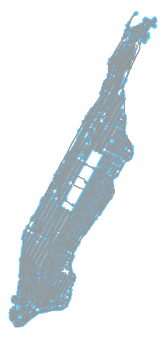

In [87]:
%matplotlib inline

location = 'manhattan'
filename = 'street_graph' + '.graphml'
directory = 'data/' + location + '/'

if not os.path.exists(directory + filename):
    print("Graph file doesn't exist locally, re-downloading...")
    G = ox.graph_from_place('Manhattan, New York', network_type='drive')
    G = ox.projection.project_graph(G)
    ox.save_graphml(G, filename=filename, folder=directory)
else:
    G = ox.load_graphml(filename=filename, folder=directory)

fig, ax = ox.plot_graph(G)


In [88]:
class TaxiDataset:
    def __init__(self, location, coords, timestamps):
        self.location = location
        self.coords = coords
        self.timestamps = timestamps

In [89]:
import pandas as pd
import utm
from datetime import datetime

def to_utm(long, lat):
    x, y, _, _ = utm.from_latlon(lat, long)
    return x, y


def fetch_taxi_dataset(location='manhattan', date='2016-01'):
    if location == 'manhattan':
        filename = date + '-01-01.txt'
        filepath = 'data/manhattan/processed/2016-01/' + filename
        coords = []
        with open(filepath, 'r') as f:
            for line in f:
                xy = line.split()
                coords.append((float(xy[0]), float(xy[1])))
        return TaxiDataset(location, coords, [])

    elif location == 'porto':
        filename = 'train.csv'
        filepath = 'data/' + location + '/' + filename

        df = pd.read_csv(filepath, usecols=['TIMESTAMP', 'POLYLINE'])
        coords = []
        timestamps = []
        for ts, line in tqdm(zip(df['TIMESTAMP'], df['POLYLINE'])):
            end = line.index(']')
            raw_coords = line[:end].split(',')
            if len(raw_coords) < 2:
                continue
            timestamps.append(datetime.fromtimestamp(int(ts)))
            long = float(raw_coords[0][2:])
            lat = float(raw_coords[1])
            coords.append(to_utm(long, lat))
        return TaxiDataset(location, coords, timestamps)


td = fetch_taxi_dataset()

In [90]:
from sklearn.neighbors import KDTree

tp = np.array(td.coords[1])
nodes, _ = ox.graph_to_gdfs(G)
kd = KDTree(nodes[['x', 'y']], metric='euclidean')

idx = kd.query([tp], k=1, return_distance=False)[0]
closest_node = nodes.iloc[idx].index.values[0]
print(tp, (G.node[closest_node]['x'], G.node[closest_node]['y']))

[ 594830.18157746 4513864.06224313] (590228.0389144608, 4516525.679110034)


In [91]:
project_count = defaultdict(int)

remaining = []

for p in td.coords:
    dis, idx = kd.query([p])
    closest_node = nodes.iloc[idx[0]].index.values[0]
    if dis[0][0] > 100:
        continue
    project_count[closest_node] += 1
    remaining.append(p)

td.coords = remaining
print(len(remaining))

  0%|          | 0/57213 [00:00<?, ?it/s]

  0%|          | 102/57213 [00:00<00:56, 1016.89it/s]

  0%|          | 266/57213 [00:00<00:49, 1147.65it/s]

  1%|          | 371/57213 [00:00<00:50, 1114.77it/s]

  1%|          | 452/57213 [00:00<01:09, 817.38it/s] 

  1%|          | 524/57213 [00:00<01:38, 573.03it/s]

  1%|          | 628/57213 [00:00<01:25, 662.07it/s]

  1%|          | 702/57213 [00:00<01:26, 649.79it/s]

  1%|▏         | 796/57213 [00:01<01:18, 715.25it/s]

  2%|▏         | 874/57213 [00:01<01:17, 727.48it/s]

  2%|▏         | 955/57213 [00:01<01:15, 750.01it/s]

  2%|▏         | 1033/57213 [00:01<01:24, 662.28it/s]

  2%|▏         | 1111/57213 [00:01<01:21, 692.56it/s]

  2%|▏         | 1201/57213 [00:01<01:15, 743.78it/s]

  2%|▏         | 1322/57213 [00:01<01:06, 840.85it/s]

  2%|▏         | 1420/57213 [00:01<01:03, 877.03it/s]

  3%|▎         | 1540/57213 [00:01<00:58, 953.49it/s]

  3%|▎         | 1676/57213 [00:01<00:53, 1046.71it/s]

  3%|▎         | 1838/57213 [00:02<00:47, 1167.13it/s]

  4%|▎         | 2009/57213 [00:02<00:42, 1289.89it/s]

  4%|▍         | 2244/57213 [00:02<00:36, 1491.51it/s]

  4%|▍         | 2463/57213 [00:02<00:33, 1648.35it/s]

  5%|▍         | 2647/57213 [00:02<00:34, 1568.93it/s]

  5%|▍         | 2818/57213 [00:02<00:37, 1469.65it/s]

  5%|▌         | 2976/57213 [00:02<00:36, 1473.82it/s]

  5%|▌         | 3133/57213 [00:02<00:36, 1500.40it/s]

  6%|▌         | 3315/57213 [00:02<00:34, 1582.27it/s]

  6%|▌         | 3503/57213 [00:03<00:32, 1660.33it/s]

  6%|▋         | 3674/57213 [00:03<00:32, 1632.20it/s]

  7%|▋         | 3841/57213 [00:03<00:32, 1619.56it/s]

  7%|▋         | 4006/57213 [00:03<00:33, 1589.89it/s]

  7%|▋         | 4167/57213 [00:03<00:33, 1567.22it/s]

  8%|▊         | 4337/57213 [00:03<00:32, 1603.47it/s]

  8%|▊         | 4504/57213 [00:03<00:32, 1622.42it/s]

  8%|▊         | 4668/57213 [00:03<00:33, 1591.38it/s]

  8%|▊         | 4835/57213 [00:03<00:32, 1612.43it/s]

  9%|▊         | 4997/57213 [00:04<00:36, 1413.12it/s]

  9%|▉         | 5144/57213 [00:04<00:43, 1203.46it/s]

  9%|▉         | 5274/57213 [00:04<00:44, 1166.43it/s]

  9%|▉         | 5426/57213 [00:04<00:41, 1253.84it/s]

 10%|▉         | 5562/57213 [00:04<00:51, 997.77it/s] 

 10%|▉         | 5675/57213 [00:04<01:08, 752.02it/s]

 10%|█         | 5769/57213 [00:04<01:07, 761.87it/s]

 10%|█         | 5879/57213 [00:05<01:01, 838.89it/s]

 10%|█         | 5975/57213 [00:05<01:06, 770.46it/s]

 11%|█         | 6089/57213 [00:05<01:00, 848.79it/s]

 11%|█         | 6183/57213 [00:05<01:00, 840.27it/s]

 11%|█         | 6284/57213 [00:05<00:57, 883.45it/s]

 11%|█         | 6417/57213 [00:05<00:51, 981.72it/s]

 11%|█▏        | 6576/57213 [00:05<00:45, 1108.55it/s]

 12%|█▏        | 6703/57213 [00:05<00:43, 1152.09it/s]

 12%|█▏        | 6838/57213 [00:05<00:41, 1203.00it/s]

 12%|█▏        | 6972/57213 [00:06<00:40, 1240.78it/s]

 12%|█▏        | 7151/57213 [00:06<00:36, 1366.38it/s]

 13%|█▎        | 7335/57213 [00:06<00:33, 1480.49it/s]

 13%|█▎        | 7491/57213 [00:06<00:34, 1459.07it/s]

 13%|█▎        | 7678/57213 [00:06<00:31, 1561.12it/s]

 14%|█▎        | 7866/57213 [00:06<00:30, 1643.00it/s]

 14%|█▍        | 8051/57213 [00:06<00:28, 1699.08it/s]

 14%|█▍        | 8226/57213 [00:06<00:29, 1673.65it/s]

 15%|█▍        | 8416/57213 [00:06<00:28, 1731.92it/s]

 15%|█▌        | 8592/57213 [00:06<00:30, 1573.14it/s]

 15%|█▌        | 8754/57213 [00:07<00:31, 1545.05it/s]

 16%|█▌        | 8912/57213 [00:07<00:31, 1534.91it/s]

 16%|█▌        | 9072/57213 [00:07<00:31, 1552.04it/s]

 16%|█▌        | 9229/57213 [00:07<00:37, 1263.26it/s]

 16%|█▋        | 9394/57213 [00:07<00:35, 1358.03it/s]

 17%|█▋        | 9593/57213 [00:07<00:31, 1499.31it/s]

 17%|█▋        | 9754/57213 [00:07<00:33, 1433.68it/s]

 17%|█▋        | 9906/57213 [00:07<00:33, 1416.08it/s]

 18%|█▊        | 10100/57213 [00:08<00:30, 1539.50it/s]

 18%|█▊        | 10299/57213 [00:08<00:28, 1649.97it/s]

 18%|█▊        | 10472/57213 [00:08<00:29, 1601.13it/s]

 19%|█▊        | 10645/57213 [00:08<00:28, 1635.81it/s]

 19%|█▉        | 10813/57213 [00:08<00:29, 1594.12it/s]

 19%|█▉        | 10976/57213 [00:08<00:31, 1465.54it/s]

 19%|█▉        | 11139/57213 [00:08<00:30, 1506.83it/s]

 20%|█▉        | 11293/57213 [00:08<00:31, 1453.69it/s]

 20%|██        | 11451/57213 [00:08<00:30, 1488.51it/s]

 20%|██        | 11640/57213 [00:08<00:28, 1589.77it/s]

 21%|██        | 11833/57213 [00:09<00:27, 1676.12it/s]

 21%|██        | 12025/57213 [00:09<00:25, 1741.08it/s]

 21%|██▏       | 12218/57213 [00:09<00:25, 1792.56it/s]

 22%|██▏       | 12409/57213 [00:09<00:24, 1826.01it/s]

 22%|██▏       | 12594/57213 [00:09<00:24, 1811.53it/s]

 22%|██▏       | 12777/57213 [00:09<00:24, 1782.07it/s]

 23%|██▎       | 12961/57213 [00:09<00:24, 1797.24it/s]

 23%|██▎       | 13147/57213 [00:09<00:24, 1813.65it/s]

 23%|██▎       | 13338/57213 [00:09<00:23, 1840.45it/s]

 24%|██▎       | 13523/57213 [00:09<00:23, 1820.68it/s]

 24%|██▍       | 13746/57213 [00:10<00:22, 1926.06it/s]

 24%|██▍       | 13941/57213 [00:10<00:22, 1931.52it/s]

 25%|██▍       | 14155/57213 [00:10<00:21, 1989.38it/s]

 25%|██▌       | 14365/57213 [00:10<00:21, 2020.68it/s]

 25%|██▌       | 14583/57213 [00:10<00:20, 2064.04it/s]

 26%|██▌       | 14801/57213 [00:10<00:20, 2095.34it/s]

 26%|██▌       | 15012/57213 [00:10<00:20, 2020.35it/s]

 27%|██▋       | 15216/57213 [00:10<00:20, 2023.23it/s]

 27%|██▋       | 15424/57213 [00:10<00:20, 2037.66it/s]

 27%|██▋       | 15648/57213 [00:11<00:19, 2093.29it/s]

 28%|██▊       | 15859/57213 [00:11<00:19, 2069.17it/s]

 28%|██▊       | 16067/57213 [00:11<00:20, 1968.03it/s]

 28%|██▊       | 16280/57213 [00:11<00:20, 2013.06it/s]

 29%|██▉       | 16490/57213 [00:11<00:19, 2036.31it/s]

 29%|██▉       | 16712/57213 [00:11<00:19, 2087.33it/s]

 30%|██▉       | 16946/57213 [00:11<00:18, 2155.36it/s]

 30%|██▉       | 17163/57213 [00:11<00:19, 2075.75it/s]

 30%|███       | 17381/57213 [00:11<00:18, 2104.23it/s]

 31%|███       | 17604/57213 [00:11<00:18, 2139.54it/s]

 31%|███       | 17823/57213 [00:12<00:18, 2152.82it/s]

 32%|███▏      | 18041/57213 [00:12<00:18, 2160.83it/s]

 32%|███▏      | 18258/57213 [00:12<00:18, 2136.19it/s]

 32%|███▏      | 18477/57213 [00:12<00:18, 2151.72it/s]

 33%|███▎      | 18693/57213 [00:12<00:17, 2144.22it/s]

 33%|███▎      | 18922/57213 [00:12<00:17, 2184.07it/s]

 33%|███▎      | 19149/57213 [00:12<00:17, 2208.16it/s]

 34%|███▍      | 19371/57213 [00:12<00:17, 2158.68it/s]

 34%|███▍      | 19589/57213 [00:12<00:17, 2162.82it/s]

 35%|███▍      | 19806/57213 [00:12<00:17, 2153.31it/s]

 35%|███▍      | 20022/57213 [00:13<00:17, 2126.22it/s]

 35%|███▌      | 20242/57213 [00:13<00:17, 2145.51it/s]

 36%|███▌      | 20462/57213 [00:13<00:17, 2160.75it/s]

 36%|███▌      | 20686/57213 [00:13<00:16, 2182.64it/s]

 37%|███▋      | 20905/57213 [00:13<00:16, 2184.54it/s]

 37%|███▋      | 21124/57213 [00:13<00:16, 2185.98it/s]

 37%|███▋      | 21343/57213 [00:13<00:16, 2185.36it/s]

 38%|███▊      | 21562/57213 [00:13<00:16, 2180.90it/s]

 38%|███▊      | 21784/57213 [00:13<00:16, 2190.86it/s]

 38%|███▊      | 22008/57213 [00:13<00:15, 2204.72it/s]

 39%|███▉      | 22232/57213 [00:14<00:15, 2213.05it/s]

 39%|███▉      | 22456/57213 [00:14<00:15, 2220.21it/s]

 40%|███▉      | 22679/57213 [00:14<00:15, 2191.89it/s]

 40%|████      | 22910/57213 [00:14<00:15, 2224.98it/s]

 40%|████      | 23133/57213 [00:14<00:15, 2193.82it/s]

 41%|████      | 23353/57213 [00:14<00:16, 2112.70it/s]

 41%|████      | 23566/57213 [00:14<00:16, 2093.02it/s]

 42%|████▏     | 23776/57213 [00:14<00:18, 1798.43it/s]

 42%|████▏     | 23964/57213 [00:15<00:20, 1584.54it/s]

 42%|████▏     | 24189/57213 [00:15<00:19, 1737.36it/s]

 43%|████▎     | 24377/57213 [00:15<00:18, 1777.54it/s]

 43%|████▎     | 24594/57213 [00:15<00:17, 1878.91it/s]

 43%|████▎     | 24828/57213 [00:15<00:16, 1995.53it/s]

 44%|████▍     | 25035/57213 [00:15<00:16, 2010.31it/s]

 44%|████▍     | 25252/57213 [00:15<00:15, 2054.87it/s]

 45%|████▍     | 25464/57213 [00:15<00:15, 2073.76it/s]

 45%|████▍     | 25684/57213 [00:15<00:14, 2108.01it/s]

 45%|████▌     | 25917/57213 [00:15<00:14, 2169.53it/s]

 46%|████▌     | 26136/57213 [00:16<00:14, 2082.52it/s]

 46%|████▌     | 26347/57213 [00:16<00:15, 1966.99it/s]

 46%|████▋     | 26551/57213 [00:16<00:15, 1987.66it/s]

 47%|████▋     | 26752/57213 [00:16<00:15, 1972.80it/s]

 47%|████▋     | 26964/57213 [00:16<00:15, 2013.98it/s]

 48%|████▊     | 27179/57213 [00:16<00:14, 2050.71it/s]

 48%|████▊     | 27397/57213 [00:16<00:14, 2086.79it/s]

 48%|████▊     | 27610/57213 [00:16<00:14, 2097.19it/s]

 49%|████▊     | 27831/57213 [00:16<00:13, 2128.00it/s]

 49%|████▉     | 28055/57213 [00:16<00:13, 2160.00it/s]

 49%|████▉     | 28280/57213 [00:17<00:13, 2186.23it/s]

 50%|████▉     | 28500/57213 [00:17<00:13, 2073.20it/s]

 50%|█████     | 28711/57213 [00:17<00:13, 2082.02it/s]

 51%|█████     | 28934/57213 [00:17<00:13, 2123.75it/s]

 51%|█████     | 29169/57213 [00:17<00:12, 2184.79it/s]

 51%|█████▏    | 29394/57213 [00:17<00:12, 2203.59it/s]

 52%|█████▏    | 29617/57213 [00:17<00:12, 2209.43it/s]

 52%|█████▏    | 29839/57213 [00:17<00:13, 1991.10it/s]

 53%|█████▎    | 30043/57213 [00:17<00:14, 1935.18it/s]

 53%|█████▎    | 30241/57213 [00:18<00:13, 1929.71it/s]

 53%|█████▎    | 30437/57213 [00:18<00:14, 1823.61it/s]

 54%|█████▎    | 30623/57213 [00:18<00:14, 1775.10it/s]

 54%|█████▍    | 30803/57213 [00:18<00:18, 1394.25it/s]

 54%|█████▍    | 30958/57213 [00:18<00:18, 1435.87it/s]

 54%|█████▍    | 31141/57213 [00:18<00:16, 1533.72it/s]

 55%|█████▍    | 31325/57213 [00:18<00:16, 1613.63it/s]

 55%|█████▌    | 31540/57213 [00:18<00:14, 1743.59it/s]

 56%|█████▌    | 31756/57213 [00:18<00:13, 1850.55it/s]

 56%|█████▌    | 31975/57213 [00:19<00:13, 1940.68it/s]

 56%|█████▋    | 32203/57213 [00:19<00:12, 2030.08it/s]

 57%|█████▋    | 32421/57213 [00:19<00:11, 2070.57it/s]

 57%|█████▋    | 32647/57213 [00:19<00:11, 2121.83it/s]

 57%|█████▋    | 32878/57213 [00:19<00:11, 2174.12it/s]

 58%|█████▊    | 33102/57213 [00:19<00:10, 2192.55it/s]

 58%|█████▊    | 33329/57213 [00:19<00:10, 2213.16it/s]

 59%|█████▊    | 33552/57213 [00:19<00:11, 2030.08it/s]

 59%|█████▉    | 33759/57213 [00:19<00:11, 2041.03it/s]

 59%|█████▉    | 33976/57213 [00:19<00:11, 2076.80it/s]

 60%|█████▉    | 34202/57213 [00:20<00:10, 2125.95it/s]

 60%|██████    | 34428/57213 [00:20<00:10, 2162.16it/s]

 61%|██████    | 34646/57213 [00:20<00:10, 2160.23it/s]

 61%|██████    | 34875/57213 [00:20<00:10, 2197.19it/s]

 61%|██████▏   | 35102/57213 [00:20<00:09, 2216.26it/s]

 62%|██████▏   | 35325/57213 [00:20<00:09, 2213.89it/s]

 62%|██████▏   | 35547/57213 [00:20<00:09, 2206.03it/s]

 63%|██████▎   | 35768/57213 [00:20<00:09, 2149.53it/s]

 63%|██████▎   | 35984/57213 [00:20<00:09, 2145.20it/s]

 63%|██████▎   | 36200/57213 [00:20<00:09, 2147.72it/s]

 64%|██████▎   | 36416/57213 [00:21<00:09, 2115.70it/s]

 64%|██████▍   | 36636/57213 [00:21<00:09, 2137.47it/s]

 64%|██████▍   | 36853/57213 [00:21<00:09, 2146.47it/s]

 65%|██████▍   | 37075/57213 [00:21<00:09, 2167.18it/s]

 65%|██████▌   | 37292/57213 [00:21<00:09, 2163.75it/s]

 66%|██████▌   | 37509/57213 [00:21<00:09, 2120.14it/s]

 66%|██████▌   | 37722/57213 [00:21<00:09, 2060.97it/s]

 66%|██████▋   | 37929/57213 [00:21<00:09, 2023.61it/s]

 67%|██████▋   | 38150/57213 [00:21<00:09, 2075.05it/s]

 67%|██████▋   | 38382/57213 [00:22<00:08, 2142.92it/s]

 67%|██████▋   | 38599/57213 [00:22<00:08, 2142.00it/s]

 68%|██████▊   | 38814/57213 [00:22<00:08, 2095.04it/s]

 68%|██████▊   | 39028/57213 [00:22<00:08, 2107.18it/s]

 69%|██████▊   | 39251/57213 [00:22<00:08, 2141.88it/s]

 69%|██████▉   | 39480/57213 [00:22<00:08, 2184.00it/s]

 69%|██████▉   | 39704/57213 [00:22<00:07, 2200.21it/s]

 70%|██████▉   | 39925/57213 [00:22<00:07, 2187.89it/s]

 70%|███████   | 40146/57213 [00:22<00:07, 2193.24it/s]

 71%|███████   | 40377/57213 [00:22<00:07, 2225.25it/s]

 71%|███████   | 40608/57213 [00:23<00:07, 2248.35it/s]

 71%|███████▏  | 40834/57213 [00:23<00:07, 2249.75it/s]

 72%|███████▏  | 41060/57213 [00:23<00:07, 2026.89it/s]

 72%|███████▏  | 41267/57213 [00:23<00:07, 1995.72it/s]

 73%|███████▎  | 41483/57213 [00:23<00:07, 2041.56it/s]

 73%|███████▎  | 41690/57213 [00:23<00:07, 1973.69it/s]

 73%|███████▎  | 41890/57213 [00:23<00:07, 1936.42it/s]

 74%|███████▎  | 42091/57213 [00:23<00:07, 1956.50it/s]

 74%|███████▍  | 42288/57213 [00:23<00:07, 1948.99it/s]

 74%|███████▍  | 42499/57213 [00:24<00:07, 1990.91it/s]

 75%|███████▍  | 42699/57213 [00:24<00:08, 1710.76it/s]

 75%|███████▍  | 42899/57213 [00:24<00:08, 1786.79it/s]

 75%|███████▌  | 43092/57213 [00:24<00:07, 1826.90it/s]

 76%|███████▌  | 43316/57213 [00:24<00:07, 1932.20it/s]

 76%|███████▌  | 43540/57213 [00:24<00:06, 2013.55it/s]

 76%|███████▋  | 43766/57213 [00:24<00:06, 2079.70it/s]

 77%|███████▋  | 44003/57213 [00:24<00:06, 2157.96it/s]

 77%|███████▋  | 44237/57213 [00:24<00:05, 2207.46it/s]

 78%|███████▊  | 44464/57213 [00:24<00:05, 2224.38it/s]

 78%|███████▊  | 44689/57213 [00:25<00:05, 2145.60it/s]

 79%|███████▊  | 44919/57213 [00:25<00:05, 2189.43it/s]

 79%|███████▉  | 45155/57213 [00:25<00:05, 2237.83it/s]

 79%|███████▉  | 45387/57213 [00:25<00:05, 2259.88it/s]

 80%|███████▉  | 45614/57213 [00:25<00:05, 2249.11it/s]

 80%|████████  | 45841/57213 [00:25<00:05, 2253.03it/s]

 81%|████████  | 46067/57213 [00:25<00:04, 2246.07it/s]

 81%|████████  | 46293/57213 [00:25<00:04, 2249.41it/s]

 81%|████████▏ | 46529/57213 [00:25<00:04, 2280.76it/s]

 82%|████████▏ | 46760/57213 [00:25<00:04, 2288.62it/s]

 82%|████████▏ | 46990/57213 [00:26<00:04, 2262.11it/s]

 83%|████████▎ | 47224/57213 [00:26<00:04, 2282.01it/s]

 83%|████████▎ | 47453/57213 [00:26<00:04, 2279.57it/s]

 83%|████████▎ | 47691/57213 [00:26<00:04, 2308.40it/s]

 84%|████████▍ | 47931/57213 [00:26<00:03, 2334.32it/s]

 84%|████████▍ | 48165/57213 [00:26<00:03, 2297.38it/s]

 85%|████████▍ | 48396/57213 [00:26<00:03, 2242.69it/s]

 85%|████████▍ | 48621/57213 [00:26<00:03, 2199.09it/s]

 85%|████████▌ | 48842/57213 [00:26<00:03, 2122.66it/s]

 86%|████████▌ | 49056/57213 [00:27<00:03, 2096.17it/s]

 86%|████████▌ | 49267/57213 [00:27<00:03, 2044.54it/s]

 86%|████████▋ | 49473/57213 [00:27<00:03, 2036.09it/s]

 87%|████████▋ | 49682/57213 [00:27<00:03, 2051.04it/s]

 87%|████████▋ | 49892/57213 [00:27<00:03, 2064.09it/s]

 88%|████████▊ | 50099/57213 [00:27<00:03, 2036.89it/s]

 88%|████████▊ | 50303/57213 [00:27<00:03, 1962.27it/s]

 88%|████████▊ | 50503/57213 [00:27<00:03, 1973.17it/s]

 89%|████████▊ | 50735/57213 [00:27<00:03, 2064.67it/s]

 89%|████████▉ | 50950/57213 [00:27<00:02, 2089.46it/s]

 89%|████████▉ | 51161/57213 [00:28<00:02, 2043.45it/s]

 90%|████████▉ | 51375/57213 [00:28<00:02, 2070.73it/s]

 90%|█████████ | 51589/57213 [00:28<00:02, 2090.18it/s]

 91%|█████████ | 51824/57213 [00:28<00:02, 2160.58it/s]

 91%|█████████ | 52046/57213 [00:28<00:02, 2178.07it/s]

 91%|█████████▏| 52265/57213 [00:28<00:02, 2002.67it/s]

 92%|█████████▏| 52469/57213 [00:28<00:02, 1935.71it/s]

 92%|█████████▏| 52689/57213 [00:28<00:02, 2007.78it/s]

 92%|█████████▏| 52902/57213 [00:28<00:02, 2041.03it/s]

 93%|█████████▎| 53138/57213 [00:29<00:01, 2126.65it/s]

 93%|█████████▎| 53361/57213 [00:29<00:01, 2155.94it/s]

 94%|█████████▎| 53579/57213 [00:29<00:01, 2157.44it/s]

 94%|█████████▍| 53811/57213 [00:29<00:01, 2203.71it/s]

 94%|█████████▍| 54047/57213 [00:29<00:01, 2246.26it/s]

 95%|█████████▍| 54273/57213 [00:29<00:01, 2232.29it/s]

 95%|█████████▌| 54497/57213 [00:29<00:01, 2232.02it/s]

 96%|█████████▌| 54733/57213 [00:29<00:01, 2268.66it/s]

 96%|█████████▌| 54961/57213 [00:29<00:00, 2263.62it/s]

 96%|█████████▋| 55197/57213 [00:29<00:00, 2289.27it/s]

 97%|█████████▋| 55429/57213 [00:30<00:00, 2298.09it/s]

 97%|█████████▋| 55660/57213 [00:30<00:00, 2279.53it/s]

 98%|█████████▊| 55889/57213 [00:30<00:00, 2275.03it/s]

 98%|█████████▊| 56125/57213 [00:30<00:00, 2298.39it/s]

 99%|█████████▊| 56355/57213 [00:30<00:00, 2275.82it/s]

 99%|█████████▉| 56587/57213 [00:30<00:00, 2288.57it/s]

 99%|█████████▉| 56816/57213 [00:30<00:00, 2246.31it/s]

100%|█████████▉| 57044/57213 [00:30<00:00, 2255.89it/s]

100%|██████████| 57213/57213 [00:30<00:00, 1856.95it/s]

45373


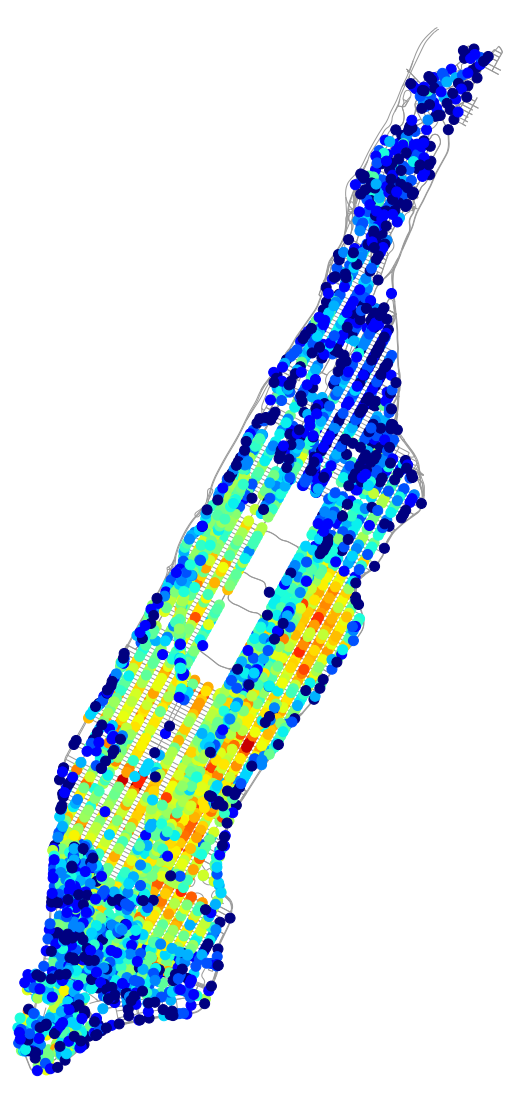

In [92]:
# Regular Projection 
import matplotlib.colors as colors

fig, ax = ox.plot_graph(G, fig_height=20, show=False, close=False, node_size=0)

x = []
y = []
c = []
for id, val in project_count.items():
    x.append(G.node[id]['x'])
    y.append(G.node[id]['y'])
    c.append(val)
    
ax.scatter(x, y, c=c, cmap='jet', norm=colors.LogNorm(), s=100, zorder=3)


500.0
49034.270448333


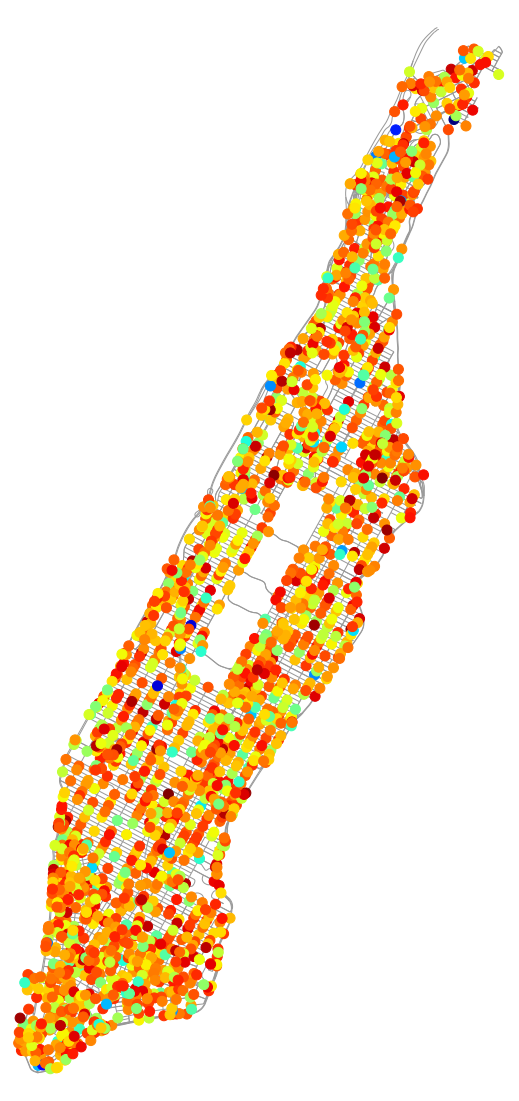

In [119]:
# Basic Laplacian mechanism

dp_eps = 0.01
l2_sens = 5.

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, fig_height=20)

error = 0.
sigma = l2_sens / dp_eps

x = []
y = []
c = []
for id, val in project_count.items():
    x.append(G.node[id]['x'])
    y.append(G.node[id]['y'])
    lap = np.random.laplace(0, sigma)
    val += lap
    error += lap ** 2
    c.append(val)
        
ax.scatter(x, y, c=c, cmap='jet', norm=colors.LogNorm(), s=100, zorder=3)

print(sigma)
print(error / len(td.coords))

plt.show()

def basic_laplace_Y(eps, l2_sens=5):
    Y = []
    sigma = l2_sens / eps
    for n in G.to_undirected().nodes():
        if n in project_count:
            Y.append(project_count[n] + np.random.laplace(0, sigma))
        else:
            Y.append(np.random.laplace(0, sigma))
    return Y

In [94]:
from scipy.special import lambertw


def sample_laplacian2d(x_0, eps):
    theta = np.random.uniform(0, 2 * np.pi)
    p = np.random.uniform(0, 1)
    r = (-1. / eps) * (lambertw((p - 1) / np.e, k=-1) + 1)

    return np.real(np.array([x_0]) + [r * np.sin(theta), r * np.cos(theta)])


sample_laplacian2d((20, 60), 0.01)


array([[ 40.14132299, -38.60023213]])

  0%|          | 0/45373 [00:00<?, ?it/s]

  0%|          | 88/45373 [00:00<00:51, 877.65it/s]

  1%|          | 269/45373 [00:00<00:43, 1037.56it/s]

  1%|          | 397/45373 [00:00<00:40, 1100.05it/s]

  1%|          | 552/45373 [00:00<00:37, 1204.00it/s]

  2%|▏         | 681/45373 [00:00<00:36, 1227.23it/s]

  2%|▏         | 850/45373 [00:00<00:33, 1336.32it/s]

  2%|▏         | 1008/45373 [00:00<00:31, 1400.58it/s]

  3%|▎         | 1157/45373 [00:00<00:31, 1424.32it/s]

  3%|▎         | 1299/45373 [00:00<00:31, 1389.32it/s]

  3%|▎         | 1438/45373 [00:01<00:35, 1247.77it/s]

  3%|▎         | 1566/45373 [00:01<00:46, 952.11it/s] 

  4%|▎         | 1679/45373 [00:01<00:43, 998.50it/s]

  4%|▍         | 1811/45373 [00:01<00:40, 1075.57it/s]

  4%|▍         | 1927/45373 [00:01<00:41, 1056.50it/s]

  4%|▍         | 2039/45373 [00:01<00:57, 755.67it/s] 

  5%|▍         | 2131/45373 [00:02<01:15, 576.50it/s]

  5%|▍         | 2216/45373 [00:02<01:07, 637.19it/s]

  5%|▌         | 2329/45373 [00:02<00:58, 731.88it/s]

  5%|▌         | 2432/45373 [00:02<00:53, 801.47it/s]

  6%|▌         | 2579/45373 [00:02<00:46, 927.86it/s]

  6%|▌         | 2688/45373 [00:02<00:45, 932.34it/s]

  6%|▌         | 2801/45373 [00:02<00:43, 983.45it/s]

  7%|▋         | 2967/45373 [00:02<00:37, 1119.64it/s]

  7%|▋         | 3121/45373 [00:02<00:34, 1219.26it/s]

  7%|▋         | 3291/45373 [00:02<00:31, 1330.95it/s]

  8%|▊         | 3436/45373 [00:03<00:35, 1188.85it/s]

  8%|▊         | 3566/45373 [00:03<00:37, 1114.83it/s]

  8%|▊         | 3704/45373 [00:03<00:35, 1182.50it/s]

  8%|▊         | 3830/45373 [00:03<00:42, 967.99it/s] 

  9%|▉         | 3981/45373 [00:03<00:38, 1084.58it/s]

  9%|▉         | 4132/45373 [00:03<00:34, 1183.94it/s]

  9%|▉         | 4288/45373 [00:03<00:32, 1274.82it/s]

 10%|▉         | 4460/45373 [00:03<00:29, 1380.65it/s]

 10%|█         | 4608/45373 [00:04<00:29, 1373.88it/s]

 11%|█         | 4792/45373 [00:04<00:27, 1485.39it/s]

 11%|█         | 4959/45373 [00:04<00:26, 1534.87it/s]

 11%|█▏        | 5118/45373 [00:04<00:26, 1521.36it/s]

 12%|█▏        | 5292/45373 [00:04<00:25, 1579.08it/s]

 12%|█▏        | 5454/45373 [00:04<00:26, 1522.01it/s]

 12%|█▏        | 5609/45373 [00:04<00:38, 1046.31it/s]

 13%|█▎        | 5774/45373 [00:04<00:33, 1175.23it/s]

 13%|█▎        | 5942/45373 [00:05<00:30, 1287.24it/s]

 13%|█▎        | 6089/45373 [00:05<00:34, 1131.14it/s]

 14%|█▎        | 6222/45373 [00:05<00:33, 1183.95it/s]

 14%|█▍        | 6411/45373 [00:05<00:29, 1332.62it/s]

 15%|█▍        | 6612/45373 [00:05<00:26, 1481.74it/s]

 15%|█▌        | 6812/45373 [00:05<00:24, 1606.33it/s]

 15%|█▌        | 7013/45373 [00:05<00:22, 1707.88it/s]

 16%|█▌        | 7215/45373 [00:05<00:21, 1788.82it/s]

 16%|█▋        | 7413/45373 [00:05<00:20, 1842.13it/s]

 17%|█▋        | 7612/45373 [00:06<00:20, 1882.75it/s]

 17%|█▋        | 7814/45373 [00:06<00:19, 1921.64it/s]

 18%|█▊        | 8010/45373 [00:06<00:19, 1878.76it/s]

 18%|█▊        | 8201/45373 [00:06<00:27, 1361.83it/s]

 18%|█▊        | 8385/45373 [00:06<00:25, 1476.62it/s]

 19%|█▉        | 8593/45373 [00:06<00:22, 1615.88it/s]

 19%|█▉        | 8772/45373 [00:06<00:24, 1511.66it/s]

 20%|█▉        | 8937/45373 [00:06<00:26, 1395.84it/s]

 20%|██        | 9122/45373 [00:07<00:24, 1506.34it/s]

 21%|██        | 9318/45373 [00:07<00:22, 1617.42it/s]

 21%|██        | 9514/45373 [00:07<00:21, 1706.08it/s]

 21%|██▏       | 9713/45373 [00:07<00:20, 1780.65it/s]

 22%|██▏       | 9898/45373 [00:07<00:21, 1687.43it/s]

 22%|██▏       | 10073/45373 [00:07<00:25, 1377.44it/s]

 23%|██▎       | 10273/45373 [00:07<00:23, 1519.23it/s]

 23%|██▎       | 10473/45373 [00:07<00:21, 1636.59it/s]

 24%|██▎       | 10666/45373 [00:07<00:20, 1713.87it/s]

 24%|██▍       | 10847/45373 [00:08<00:25, 1344.44it/s]

 24%|██▍       | 11046/45373 [00:08<00:23, 1488.34it/s]

 25%|██▍       | 11232/45373 [00:08<00:21, 1582.86it/s]

 25%|██▌       | 11435/45373 [00:08<00:20, 1694.84it/s]

 26%|██▌       | 11642/45373 [00:08<00:18, 1791.52it/s]

 26%|██▌       | 11852/45373 [00:08<00:17, 1873.24it/s]

 27%|██▋       | 12050/45373 [00:08<00:17, 1903.16it/s]

 27%|██▋       | 12247/45373 [00:08<00:17, 1859.22it/s]

 27%|██▋       | 12438/45373 [00:08<00:18, 1773.42it/s]

 28%|██▊       | 12635/45373 [00:09<00:17, 1826.51it/s]

 28%|██▊       | 12821/45373 [00:09<00:19, 1635.43it/s]

 29%|██▊       | 12991/45373 [00:09<00:19, 1642.33it/s]

 29%|██▉       | 13160/45373 [00:09<00:24, 1317.23it/s]

 29%|██▉       | 13305/45373 [00:09<00:24, 1313.65it/s]

 30%|██▉       | 13455/45373 [00:09<00:23, 1362.56it/s]

 30%|██▉       | 13610/45373 [00:09<00:22, 1413.28it/s]

 30%|███       | 13757/45373 [00:09<00:22, 1416.06it/s]

 31%|███       | 13935/45373 [00:10<00:20, 1508.34it/s]

 31%|███       | 14110/45373 [00:10<00:19, 1572.29it/s]

 31%|███▏      | 14271/45373 [00:10<00:20, 1541.08it/s]

 32%|███▏      | 14428/45373 [00:10<00:20, 1515.34it/s]

 32%|███▏      | 14582/45373 [00:10<00:20, 1480.55it/s]

 32%|███▏      | 14732/45373 [00:10<00:25, 1189.85it/s]

 33%|███▎      | 14862/45373 [00:10<00:27, 1108.19it/s]

 33%|███▎      | 15026/45373 [00:10<00:24, 1226.56it/s]

 33%|███▎      | 15159/45373 [00:10<00:24, 1255.56it/s]

 34%|███▍      | 15347/45373 [00:11<00:21, 1393.44it/s]

 34%|███▍      | 15524/45373 [00:11<00:20, 1486.92it/s]

 35%|███▍      | 15682/45373 [00:11<00:25, 1151.69it/s]

 35%|███▍      | 15815/45373 [00:11<00:29, 1007.50it/s]

 35%|███▌      | 15932/45373 [00:11<00:30, 969.65it/s] 

 35%|███▌      | 16044/45373 [00:11<00:29, 1010.26it/s]

 36%|███▌      | 16154/45373 [00:11<00:34, 848.65it/s] 

 36%|███▌      | 16328/45373 [00:12<00:28, 1002.22it/s]

 36%|███▋      | 16511/45373 [00:12<00:24, 1158.76it/s]

 37%|███▋      | 16649/45373 [00:12<00:28, 1014.79it/s]

 37%|███▋      | 16769/45373 [00:12<00:29, 978.11it/s] 

 37%|███▋      | 16881/45373 [00:12<00:28, 1008.04it/s]

 38%|███▊      | 17061/45373 [00:12<00:24, 1160.94it/s]

 38%|███▊      | 17193/45373 [00:12<00:30, 920.58it/s] 

 38%|███▊      | 17315/45373 [00:12<00:28, 988.03it/s]

 38%|███▊      | 17429/45373 [00:13<00:33, 843.98it/s]

 39%|███▊      | 17545/45373 [00:13<00:30, 919.08it/s]

 39%|███▉      | 17705/45373 [00:13<00:26, 1052.41it/s]

 39%|███▉      | 17871/45373 [00:13<00:23, 1182.05it/s]

 40%|███▉      | 18050/45373 [00:13<00:20, 1315.00it/s]

 40%|████      | 18198/45373 [00:13<00:25, 1067.42it/s]

 40%|████      | 18373/45373 [00:13<00:22, 1208.11it/s]

 41%|████      | 18539/45373 [00:13<00:20, 1315.49it/s]

 41%|████      | 18714/45373 [00:14<00:18, 1421.27it/s]

 42%|████▏     | 18891/45373 [00:14<00:17, 1510.18it/s]

 42%|████▏     | 19054/45373 [00:14<00:17, 1498.76it/s]

 42%|████▏     | 19212/45373 [00:14<00:17, 1498.30it/s]

 43%|████▎     | 19387/45373 [00:14<00:16, 1563.30it/s]

 43%|████▎     | 19567/45373 [00:14<00:15, 1626.54it/s]

 44%|████▎     | 19753/45373 [00:14<00:15, 1689.66it/s]

 44%|████▍     | 19942/45373 [00:14<00:14, 1743.40it/s]

 44%|████▍     | 20124/45373 [00:14<00:14, 1765.17it/s]

 45%|████▍     | 20306/45373 [00:14<00:14, 1779.15it/s]

 45%|████▌     | 20486/45373 [00:15<00:16, 1536.82it/s]

 46%|████▌     | 20647/45373 [00:15<00:15, 1550.86it/s]

 46%|████▌     | 20807/45373 [00:15<00:18, 1320.65it/s]

 46%|████▌     | 20973/45373 [00:15<00:17, 1406.24it/s]

 47%|████▋     | 21165/45373 [00:15<00:15, 1527.05it/s]

 47%|████▋     | 21352/45373 [00:15<00:14, 1614.50it/s]

 47%|████▋     | 21540/45373 [00:15<00:14, 1684.03it/s]

 48%|████▊     | 21736/45373 [00:15<00:13, 1756.72it/s]

 48%|████▊     | 21939/45373 [00:16<00:12, 1828.65it/s]

 49%|████▉     | 22127/45373 [00:16<00:14, 1641.79it/s]

 49%|████▉     | 22331/45373 [00:16<00:13, 1742.69it/s]

 50%|████▉     | 22533/45373 [00:16<00:12, 1815.40it/s]

 50%|█████     | 22720/45373 [00:16<00:12, 1800.05it/s]

 50%|█████     | 22904/45373 [00:16<00:19, 1163.14it/s]

 51%|█████     | 23079/45373 [00:16<00:17, 1292.48it/s]

 51%|█████     | 23235/45373 [00:16<00:16, 1330.55it/s]

 52%|█████▏    | 23387/45373 [00:17<00:21, 1029.80it/s]

 52%|█████▏    | 23534/45373 [00:17<00:19, 1131.26it/s]

 52%|█████▏    | 23667/45373 [00:17<00:18, 1152.28it/s]

 52%|█████▏    | 23813/45373 [00:17<00:17, 1228.05it/s]

 53%|█████▎    | 23947/45373 [00:17<00:17, 1196.12it/s]

 53%|█████▎    | 24075/45373 [00:17<00:20, 1062.70it/s]

 53%|█████▎    | 24190/45373 [00:17<00:27, 783.35it/s] 

 54%|█████▎    | 24309/45373 [00:18<00:24, 872.04it/s]

 54%|█████▍    | 24502/45373 [00:18<00:20, 1043.04it/s]

 54%|█████▍    | 24631/45373 [00:18<00:20, 998.81it/s] 

 55%|█████▍    | 24749/45373 [00:18<00:20, 993.77it/s]

 55%|█████▍    | 24877/45373 [00:18<00:19, 1064.06it/s]

 55%|█████▌    | 25025/45373 [00:18<00:17, 1160.70it/s]

 55%|█████▌    | 25151/45373 [00:18<00:18, 1066.42it/s]

 56%|█████▌    | 25266/45373 [00:18<00:19, 1046.98it/s]

 56%|█████▌    | 25377/45373 [00:19<00:19, 1016.89it/s]

 56%|█████▌    | 25483/45373 [00:19<00:20, 989.47it/s] 

 56%|█████▋    | 25586/45373 [00:19<00:20, 954.87it/s]

 57%|█████▋    | 25758/45373 [00:19<00:17, 1101.44it/s]

 57%|█████▋    | 25942/45373 [00:19<00:15, 1251.66it/s]

 58%|█████▊    | 26093/45373 [00:19<00:14, 1314.04it/s]

 58%|█████▊    | 26235/45373 [00:19<00:16, 1182.18it/s]

 58%|█████▊    | 26415/45373 [00:19<00:14, 1316.81it/s]

 59%|█████▊    | 26593/45373 [00:19<00:13, 1427.75it/s]

 59%|█████▉    | 26778/45373 [00:20<00:12, 1531.20it/s]

 59%|█████▉    | 26962/45373 [00:20<00:11, 1612.09it/s]

 60%|█████▉    | 27142/45373 [00:20<00:10, 1663.69it/s]

 60%|██████    | 27326/45373 [00:20<00:10, 1712.09it/s]

 61%|██████    | 27502/45373 [00:20<00:10, 1711.61it/s]

 61%|██████    | 27677/45373 [00:20<00:10, 1691.82it/s]

 61%|██████▏   | 27856/45373 [00:20<00:10, 1719.61it/s]

 62%|██████▏   | 28051/45373 [00:20<00:09, 1782.42it/s]

 62%|██████▏   | 28234/45373 [00:20<00:09, 1796.29it/s]

 63%|██████▎   | 28415/45373 [00:20<00:09, 1784.08it/s]

 63%|██████▎   | 28595/45373 [00:21<00:09, 1737.03it/s]

 63%|██████▎   | 28771/45373 [00:21<00:09, 1741.52it/s]

 64%|██████▍   | 28946/45373 [00:21<00:09, 1742.27it/s]

 64%|██████▍   | 29128/45373 [00:21<00:09, 1764.39it/s]

 65%|██████▍   | 29312/45373 [00:21<00:08, 1786.29it/s]

 65%|██████▍   | 29491/45373 [00:21<00:09, 1710.48it/s]

 65%|██████▌   | 29663/45373 [00:21<00:10, 1444.45it/s]

 66%|██████▌   | 29816/45373 [00:21<00:11, 1387.04it/s]

 66%|██████▌   | 29967/45373 [00:21<00:10, 1420.27it/s]

 66%|██████▋   | 30166/45373 [00:22<00:09, 1552.46it/s]

 67%|██████▋   | 30354/45373 [00:22<00:09, 1636.99it/s]

 67%|██████▋   | 30524/45373 [00:22<00:10, 1402.25it/s]

 68%|██████▊   | 30675/45373 [00:22<00:10, 1429.49it/s]

 68%|██████▊   | 30875/45373 [00:22<00:09, 1561.89it/s]

 68%|██████▊   | 31077/45373 [00:22<00:08, 1675.21it/s]

 69%|██████▉   | 31277/45373 [00:22<00:08, 1759.45it/s]

 69%|██████▉   | 31477/45373 [00:22<00:07, 1823.81it/s]

 70%|██████▉   | 31672/45373 [00:22<00:07, 1859.12it/s]

 70%|███████   | 31862/45373 [00:23<00:07, 1858.03it/s]

 71%|███████   | 32053/45373 [00:23<00:07, 1871.50it/s]

 71%|███████   | 32243/45373 [00:23<00:07, 1875.23it/s]

 71%|███████▏  | 32435/45373 [00:23<00:06, 1884.51it/s]

 72%|███████▏  | 32625/45373 [00:23<00:07, 1764.85it/s]

 72%|███████▏  | 32804/45373 [00:23<00:07, 1720.97it/s]

 73%|███████▎  | 33007/45373 [00:23<00:06, 1801.43it/s]

 73%|███████▎  | 33194/45373 [00:23<00:06, 1817.04it/s]

 74%|███████▎  | 33378/45373 [00:23<00:07, 1674.74it/s]

 74%|███████▍  | 33566/45373 [00:23<00:06, 1729.70it/s]

 74%|███████▍  | 33743/45373 [00:24<00:06, 1740.45it/s]

 75%|███████▍  | 33920/45373 [00:24<00:06, 1668.23it/s]

 75%|███████▌  | 34124/45373 [00:24<00:06, 1762.84it/s]

 76%|███████▌  | 34304/45373 [00:24<00:06, 1667.42it/s]

 76%|███████▌  | 34484/45373 [00:24<00:06, 1703.20it/s]

 76%|███████▋  | 34657/45373 [00:24<00:06, 1691.07it/s]

 77%|███████▋  | 34861/45373 [00:24<00:05, 1780.95it/s]

 77%|███████▋  | 35068/45373 [00:24<00:05, 1857.56it/s]

 78%|███████▊  | 35257/45373 [00:24<00:06, 1498.62it/s]

 78%|███████▊  | 35420/45373 [00:25<00:07, 1317.79it/s]

 78%|███████▊  | 35573/45373 [00:25<00:07, 1373.75it/s]

 79%|███████▉  | 35734/45373 [00:25<00:06, 1435.43it/s]

 79%|███████▉  | 35903/45373 [00:25<00:06, 1502.42it/s]

 80%|███████▉  | 36079/45373 [00:25<00:05, 1570.28it/s]

 80%|███████▉  | 36242/45373 [00:25<00:05, 1554.90it/s]

 80%|████████  | 36411/45373 [00:25<00:05, 1592.18it/s]

 81%|████████  | 36573/45373 [00:25<00:05, 1513.98it/s]

 81%|████████  | 36728/45373 [00:26<00:10, 831.20it/s] 

 81%|████████  | 36849/45373 [00:26<00:11, 758.72it/s]

 81%|████████▏ | 36975/45373 [00:26<00:09, 860.71it/s]

 82%|████████▏ | 37117/45373 [00:26<00:08, 975.90it/s]

 82%|████████▏ | 37257/45373 [00:26<00:07, 1072.93it/s]

 83%|████████▎ | 37441/45373 [00:26<00:06, 1226.26it/s]

 83%|████████▎ | 37627/45373 [00:26<00:05, 1365.07it/s]

 83%|████████▎ | 37809/45373 [00:27<00:05, 1475.68it/s]

 84%|████████▎ | 37996/45373 [00:27<00:04, 1573.81it/s]

 84%|████████▍ | 38183/45373 [00:27<00:04, 1651.02it/s]

 85%|████████▍ | 38362/45373 [00:27<00:04, 1689.31it/s]

 85%|████████▍ | 38548/45373 [00:27<00:03, 1737.00it/s]

 85%|████████▌ | 38734/45373 [00:27<00:03, 1770.40it/s]

 86%|████████▌ | 38923/45373 [00:27<00:03, 1802.17it/s]

 86%|████████▌ | 39109/45373 [00:27<00:03, 1817.73it/s]

 87%|████████▋ | 39293/45373 [00:27<00:03, 1817.74it/s]

 87%|████████▋ | 39478/45373 [00:27<00:03, 1826.47it/s]

 87%|████████▋ | 39662/45373 [00:28<00:03, 1829.18it/s]

 88%|████████▊ | 39846/45373 [00:28<00:03, 1829.11it/s]

 88%|████████▊ | 40030/45373 [00:28<00:02, 1797.01it/s]

 89%|████████▊ | 40211/45373 [00:28<00:03, 1693.47it/s]

 89%|████████▉ | 40382/45373 [00:28<00:02, 1692.59it/s]

 89%|████████▉ | 40559/45373 [00:28<00:02, 1714.41it/s]

 90%|████████▉ | 40756/45373 [00:28<00:02, 1782.16it/s]

 90%|█████████ | 40961/45373 [00:28<00:02, 1853.05it/s]

 91%|█████████ | 41149/45373 [00:28<00:02, 1860.21it/s]

 91%|█████████ | 41337/45373 [00:28<00:02, 1841.00it/s]

 92%|█████████▏| 41522/45373 [00:29<00:02, 1803.24it/s]

 92%|█████████▏| 41725/45373 [00:29<00:01, 1864.85it/s]

 92%|█████████▏| 41913/45373 [00:29<00:02, 1706.54it/s]

 93%|█████████▎| 42101/45373 [00:29<00:01, 1754.35it/s]

 93%|█████████▎| 42305/45373 [00:29<00:01, 1830.53it/s]

 94%|█████████▎| 42496/45373 [00:29<00:01, 1853.62it/s]

 94%|█████████▍| 42684/45373 [00:29<00:01, 1846.35it/s]

 94%|█████████▍| 42871/45373 [00:29<00:01, 1852.01it/s]

 95%|█████████▍| 43071/45373 [00:29<00:01, 1892.92it/s]

 95%|█████████▌| 43274/45373 [00:30<00:01, 1931.85it/s]

 96%|█████████▌| 43481/45373 [00:30<00:00, 1969.42it/s]

 96%|█████████▋| 43688/45373 [00:30<00:00, 1997.83it/s]

 97%|█████████▋| 43889/45373 [00:30<00:00, 1994.62it/s]

 97%|█████████▋| 44098/45373 [00:30<00:00, 2021.54it/s]

 98%|█████████▊| 44307/45373 [00:30<00:00, 2039.90it/s]

 98%|█████████▊| 44513/45373 [00:30<00:00, 2043.73it/s]

 99%|█████████▊| 44723/45373 [00:30<00:00, 2059.13it/s]

 99%|█████████▉| 44930/45373 [00:30<00:00, 2034.61it/s]

 99%|█████████▉| 45137/45373 [00:30<00:00, 2043.75it/s]

100%|█████████▉| 45348/45373 [00:31<00:00, 2062.97it/s]

100%|██████████| 45373/45373 [00:31<00:00, 1460.47it/s]

390744.0


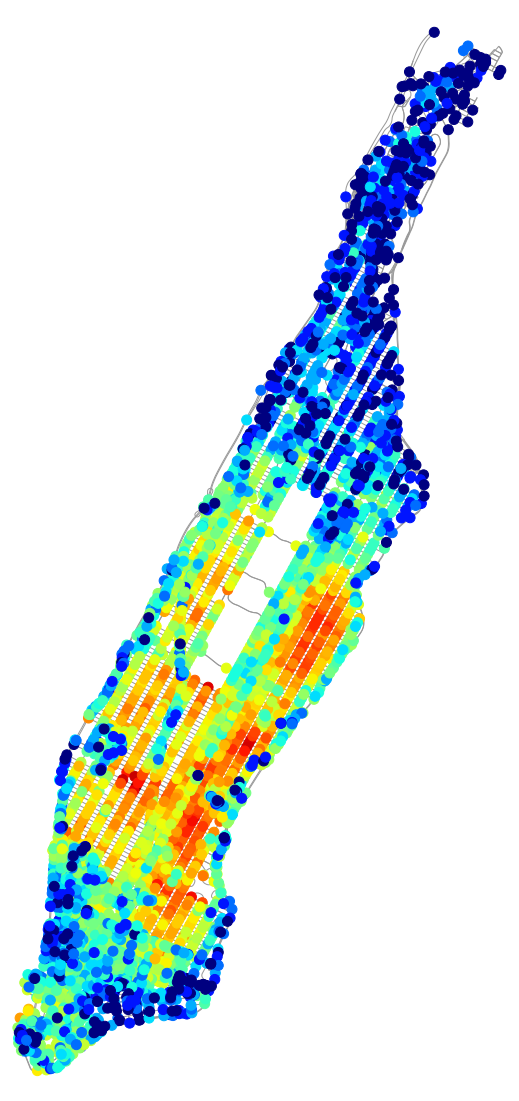

In [96]:
# 2D Laplacian mechanism

obfus_project_count = defaultdict(int)

for p in tqdm(td.coords):
    p = sample_laplacian2d(p, 0.01)
    idx = kd.query(p, k=1, return_distance=False)[0]
    closest_node = nodes.iloc[idx].index.values[0]
    obfus_project_count[closest_node] += 1
    
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, fig_height=20)

error = 0.

x = []
y = []
c = []
for id in obfus_project_count:
    x.append(G.node[id]['x'])
    y.append(G.node[id]['y'])
    error += (obfus_project_count[id] - project_count[id]) ** 2
    val = obfus_project_count[id]
    c.append(val)

ax.scatter(x, y, c=c, cmap='jet', norm=colors.LogNorm(), s=100, zorder=3)

for id in project_count:
    if id not in obfus_project_count:
        error += project_count[id]

print(error)

plt.show()

# def laplace_2d_Y(eps, l2_sens=5):
#     Y = []
#     sigma = l2_sens / (eps * len(td.coords))
#     for n in G.to_undirected().nodes():
#         if n in project_count:
#             Y.append(project_count[n] + np.random.laplace(0, sigma))
#         else:
#             Y.append(0)
#     return Y

30.713977149321433


57.95424287747748


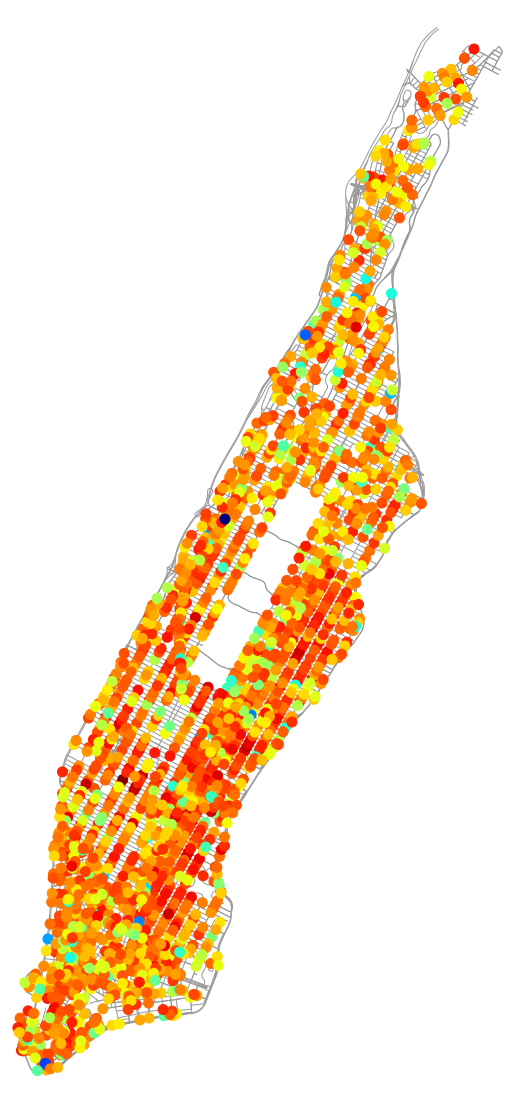

In [71]:
# Gaussian Mechanism

eps = 1
delta = 0.0001
l2_sens = 5
c = 2 * np.sqrt(np.log(1.25 / delta)) 
sigma = c * l2_sens / eps
print(sigma)

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, fig_height=20)

error = 0.

x = []
y = []
c = []
for id, val in project_count.items():
    x.append(G.node[id]['x'])
    y.append(G.node[id]['y'])
    noise = np.random.normal(0, sigma)
    val += noise
    error += noise ** 2
    c.append(val)
    
ax.scatter(x, y, c=c, cmap='jet', norm=colors.LogNorm(), s=100, zorder=3)

print(error / len(td.coords))

def basic_guassian_Y(eps, l2_sens=5, delta=0.0001):
    Y = []
    c = 2 * np.sqrt(np.log(1.25 / delta)) 
    sigma = c * l2_sens / eps
    for n in G.to_undirected().nodes():
        if n in project_count:
            Y.append(project_count[n] + np.random.normal(0, sigma))
        else:
            Y.append(0)
    return Y

In [97]:
from math import exp, sqrt
from scipy.special import erf

def calibrateAnalyticGaussianMechanism(epsilon, delta, GS, tol = 1.e-12):
    """ Calibrate a Gaussian perturbation for differential privacy using the analytic Gaussian mechanism of [Balle and Wang, ICML'18]
    Arguments:
    epsilon : target epsilon (epsilon > 0)
    delta : target delta (0 < delta < 1)
    GS : upper bound on L2 global sensitivity (GS >= 0)
    tol : error tolerance for binary search (tol > 0)
    Output:
    sigma : standard deviation of Gaussian noise needed to achieve (epsilon,delta)-DP under global sensitivity GS
    """

    def Phi(t):
        return 0.5*(1.0 + erf(float(t)/sqrt(2.0)))

    def caseA(epsilon,s):
        return Phi(sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def caseB(epsilon,s):
        return Phi(-sqrt(epsilon*s)) - exp(epsilon)*Phi(-sqrt(epsilon*(s+2.0)))

    def doubling_trick(predicate_stop, s_inf, s_sup):
        while(not predicate_stop(s_sup)):
            s_inf = s_sup
            s_sup = 2.0*s_inf
        return s_inf, s_sup

    def binary_search(predicate_stop, predicate_left, s_inf, s_sup):
        s_mid = s_inf + (s_sup-s_inf)/2.0
        while(not predicate_stop(s_mid)):
            if (predicate_left(s_mid)):
                s_sup = s_mid
            else:
                s_inf = s_mid
            s_mid = s_inf + (s_sup-s_inf)/2.0
        return s_mid

    delta_thr = caseA(epsilon, 0.0)

    if (delta == delta_thr):
        alpha = 1.0

    else:
        if (delta > delta_thr):
            predicate_stop_DT = lambda s : caseA(epsilon, s) >= delta
            function_s_to_delta = lambda s : caseA(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) > delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) - sqrt(s/2.0)

        else:
            predicate_stop_DT = lambda s : caseB(epsilon, s) <= delta
            function_s_to_delta = lambda s : caseB(epsilon, s)
            predicate_left_BS = lambda s : function_s_to_delta(s) < delta
            function_s_to_alpha = lambda s : sqrt(1.0 + s/2.0) + sqrt(s/2.0)

        predicate_stop_BS = lambda s : abs(function_s_to_delta(s) - delta) <= tol

        s_inf, s_sup = doubling_trick(predicate_stop_DT, 0.0, 1.0)
        s_final = binary_search(predicate_stop_BS, predicate_left_BS, s_inf, s_sup)
        alpha = function_s_to_alpha(s_final)
        
    sigma = alpha*GS/sqrt(2.0*epsilon)

    return sigma

15.928514943956632


24.1857235337857


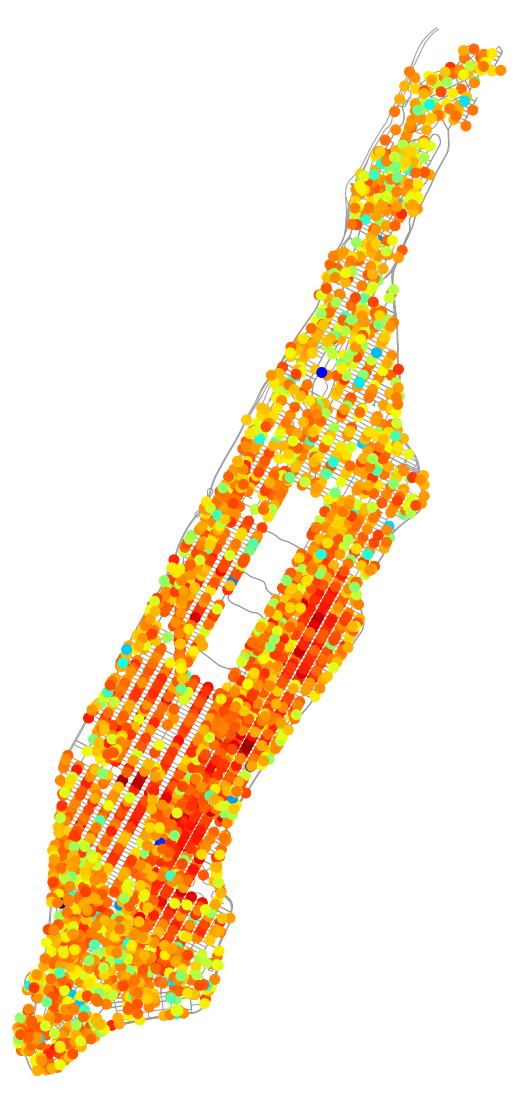

In [98]:
# eps = 0.01
# delta = 0.0001
# l2_sens = 5
sigma = calibrateAnalyticGaussianMechanism(eps, delta, l2_sens)
print(sigma)

fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0,fig_height=20)

error = 0.

x = []
y = []
c = []
for id, val in project_count.items():
    x.append(G.node[id]['x'])
    y.append(G.node[id]['y'])
    noise = np.random.normal(0, sigma)
    val += noise
    error += noise ** 2
    c.append(val)

ax.scatter(x, y, c=c, cmap='jet', norm=colors.LogNorm(), s=100, zorder=3)


print(error / len(td.coords))

def analytic_guassian_Y(eps, l2_sens=5, delta=0.00001):
    Y = [] 
    sigma = calibrateAnalyticGaussianMechanism(eps, delta, l2_sens)
    for n in G.to_undirected().nodes():
        if n in project_count:
            Y.append(project_count[n] + np.random.normal(0, sigma))
        else:
            Y.append(0)
    return Y

In [120]:
# laplacian smoothing
from networkx import laplacian_matrix
from scipy.sparse import identity

undirected_G = G.to_undirected()
L = laplacian_matrix(undirected_G, weight=None)
Y = []
for n in undirected_G.nodes():
    if n in project_count:
        Y.append(project_count[n])
    else:
        Y.append(0)
        
base_Y = np.array(Y)
mu = 0.25
k = 10
smooth = (identity(len(Y)) - mu * L) ** k
Y_s = smooth * basic_laplace_Y(eps=0.1)
print(np.mean((base_Y - Y_s) ** 2))

290.2179586408075


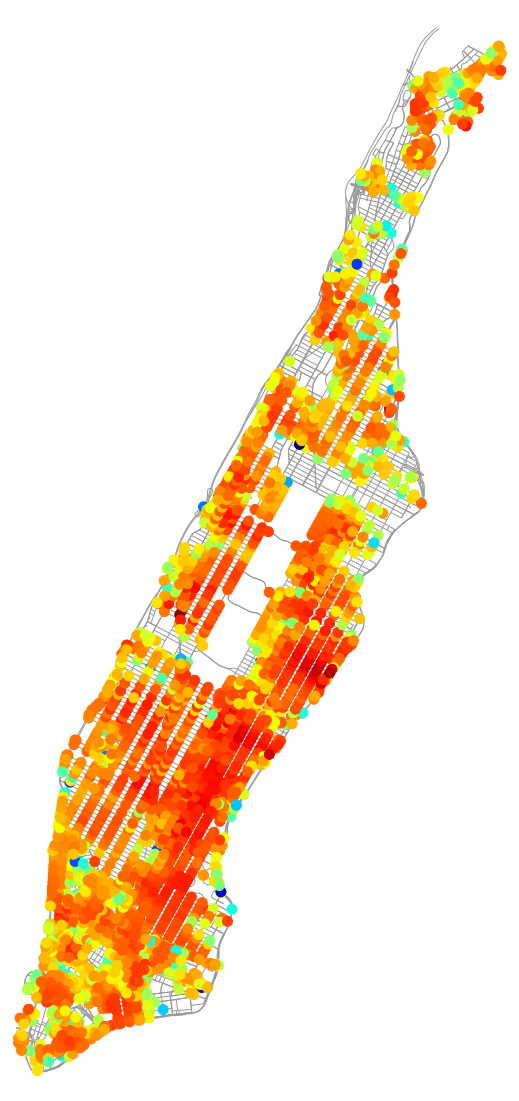

In [121]:
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, fig_height=20)

i = 0    
x = []
y = []
c = []
for n in undirected_G.nodes():
    x.append(G.node[n]['x'])
    y.append(G.node[n]['y'])
    c.append(Y_s[i])
    i += 1

ax.scatter(x, y, c=c, cmap='jet', norm=colors.LogNorm(), s=100, zorder=3)

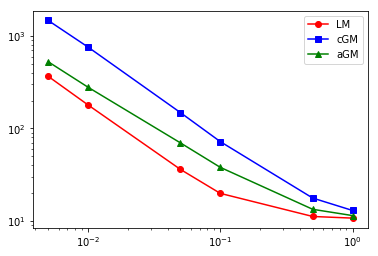

In [ ]:
eps = [0.005, 0.01, 0.05, 0.1, 0.5, 1]
lap = []
gau = []
agau = []

for e in eps:
    Y_s = smooth * basic_laplace_Y(eps=e)
    lap.append(np.sqrt(np.mean((base_Y - Y_s) ** 2)))
    Y_s = smooth * basic_guassian_Y(eps=e)
    gau.append(np.sqrt(np.mean((base_Y - Y_s) ** 2)))
    Y_s = smooth * analytic_guassian_Y(eps=e)
    agau.append(np.sqrt(np.mean((base_Y - Y_s) ** 2)))


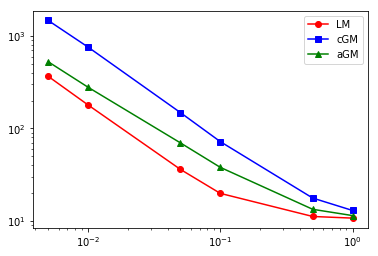

In [116]:
lap_line = plt.plot(eps[:-1], lap[:-1], 'ro-', label='LM')
gau_line = plt.plot(eps[:-1], gau[:-1], 'bs-', label='cGM')
agau_line = plt.plot(eps[:-1], agau[:-1], 'g^-', label='aGM')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [130]:
# Calman Filter

G[42437559]

AdjacencyView({42433537: {0: {'osmid': 5670536, 'oneway': True, 'name': 'Catherine Street', 'highway': 'residential', 'maxspeed': '25 mph', 'length': 61.61899999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a37c836d8>}}, 1773066054: {0: {'osmid': 195745925, 'oneway': True, 'name': 'Bowery', 'highway': 'primary', 'length': 11.991, 'geometry': <shapely.geometry.linestring.LineString object at 0x1a37c83a58>}}})